In [9]:
#--------------------- IMPORTATION DE BIBLIOTHEQUES -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [10]:
#------- PREPARATION DU DATASET ------------------
data = pd.read_csv("StudentPerformanceFactors.csv")
#afficher les 2 premiers lignes
print("Lignes, Colonnes:", data.shape) # (data.shape : t3tik l couple(l,C))
print(data.head(2))

print("\nInfo:")
print(data.info())

print("\nVariables manquantes:")
print(data.isnull().sum())

Lignes, Colonnes: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Yes                  0           Low          Medium   
1             Yes                  2        Medium          Medium   

  School_Type Peer_Influence  Physical_Activity Learning_Disabilities  \
0      Public       Positive                  3                    No   
1      Public       Negative                  4                    No   

  Parental_Education_Level Distance_from_Home  Gender  Exam_Score  
0             

In [11]:
#--------- FIXER LES VALEURS MANQUANTES ------------

cat_missing = ["Teacher_Quality", "Parental_Education_Level", "Distance_from_Home"]
for col in cat_missing:
    data[col] = data[col].fillna(data[col].mode()[0])  # <- fixed FutureWarning

print("\nValeurs manquantes après nettoyage:")
print(data.isnull().sum())


Valeurs manquantes après nettoyage:
Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


In [12]:
#--------- VARIABLE TARGET ( y )-------------
data["Success"] = (data["Exam_Score"] >= 70).astype(int)
print(f"\nSuccess rate (>= 70): {data['Success'].mean():.2%}")


Success rate (>= 70): 24.60%


In [13]:
#---------- PREPARATION FEATURES ----------

df_features = data.drop(columns=["Exam_Score"]) # les X mta3i

categorical_cols = df_features.select_dtypes(include=["object"]).columns
numeric_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.drop("Success")

print("\nColonnes catégorielles:", list(categorical_cols))
print("Colonnes numériques:", list(numeric_cols))



Colonnes catégorielles: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Colonnes numériques: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


In [14]:
#--------- SCALING DES NUMERIQUES -------------

scaler = StandardScaler()
df_features[numeric_cols] = scaler.fit_transform(df_features[numeric_cols])

In [16]:
#--------- ONE HOT ENCODING -----------------

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(df_features[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df.index = df_features.index

In [17]:
#-------- DATASET FINAL -----------------

dcopyfinal = pd.concat([df_features[numeric_cols], encoded_df, df_features["Success"]], axis=1)
print("\nShape Final:", dcopyfinal.shape)
print(dcopyfinal.head(2))


Shape Final: (6607, 41)
   Hours_Studied  Attendance  Sleep_Hours  Previous_Scores  Tutoring_Sessions  \
0       0.504942    0.348375    -0.019796         -0.14380          -1.213934   
1      -0.162822   -1.383736     0.661399         -1.11611           0.411451   

   Physical_Activity  Parental_Involvement_High  Parental_Involvement_Low  \
0           0.031411                        0.0                       1.0   
1           1.001199                        0.0                       1.0   

   Parental_Involvement_Medium  Access_to_Resources_High  ...  \
0                          0.0                       1.0  ...   
1                          0.0                       0.0  ...   

   Learning_Disabilities_Yes  Parental_Education_Level_College  \
0                        0.0                               0.0   
1                        0.0                               1.0   

   Parental_Education_Level_High School  \
0                                   1.0   
1                 

In [18]:
#---------------------- TRAIN / TEST SPLIT ----------------------------

X = dcopyfinal.drop(columns=["Success"])
y = dcopyfinal["Success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
#---------------------- LOGISTIC REGRESSION --------------------------

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

In [20]:
#---------------------- EVALUATION -----------------------------------

print("\nAccuracy:", accuracy_score(y_test, pred))
print("Cross-validation accuracy:", cross_val_score(model, X, y, cv=5).mean())
print("\nClassification Report:\n", classification_report(y_test, pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))



Accuracy: 0.9788199697428139
Cross-validation accuracy: 0.980627613289799

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.98      0.94      0.96       325

    accuracy                           0.98      1322
   macro avg       0.98      0.96      0.97      1322
weighted avg       0.98      0.98      0.98      1322


Confusion Matrix:
 [[990   7]
 [ 21 304]]


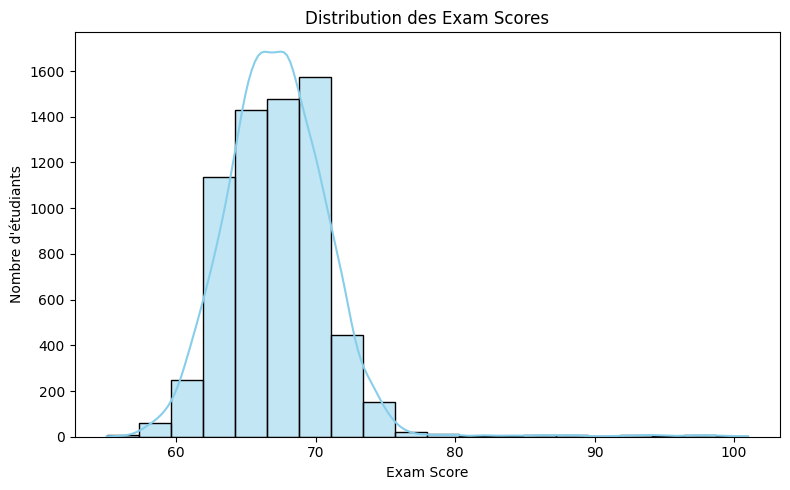

In [21]:
# 1) Histogram of Exam Scores
plt.figure(figsize=(8,5))
sns.histplot(data=data, x="Exam_Score", bins=20, kde=True, color="skyblue")
plt.title("Distribution des Exam Scores")
plt.xlabel("Exam Score")
plt.ylabel("Nombre d'étudiants")
plt.tight_layout()
plt.show()


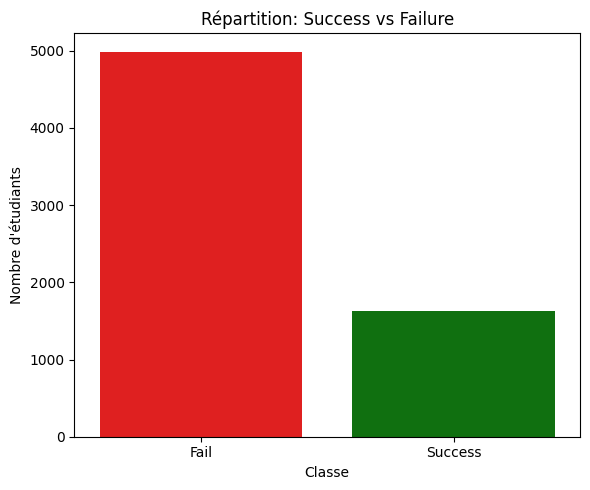

In [22]:
# 2) Success vs Failure
plt.figure(figsize=(6,5))
counts = data["Success"].value_counts().sort_index()
df_counts = pd.DataFrame({
    "Class": ["Fail","Success"],
    "Count": counts.values
})
sns.barplot(
    data=df_counts,
    x="Class",
    y="Count",
    hue="Class",
    palette={"Fail":"red","Success":"green"},
    dodge=False,
    legend=False
)
plt.title("Répartition: Success vs Failure")
plt.xlabel("Classe")
plt.ylabel("Nombre d'étudiants")
plt.tight_layout()
plt.show()

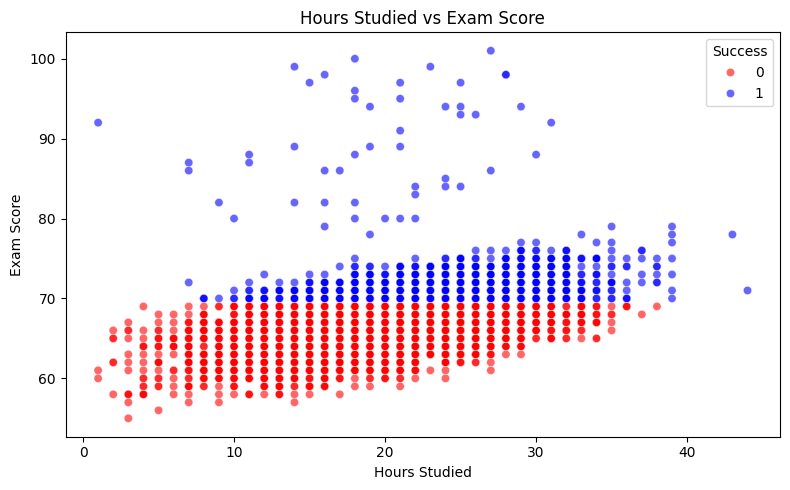

In [23]:
# 3) Hours Studied vs Exam Score
if "Hours_Studied" in data.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x=data["Hours_Studied"], 
        y=data["Exam_Score"], 
        hue=data["Success"], 
        palette={0:"red",1:"blue"}, 
        alpha=0.6
    )
    plt.title("Hours Studied vs Exam Score")
    plt.xlabel("Hours Studied")
    plt.ylabel("Exam Score")
    plt.tight_layout()
    plt.show()

C:\Users\hedib\AppData\Local\Temp\ipykernel_22156\3209680043.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


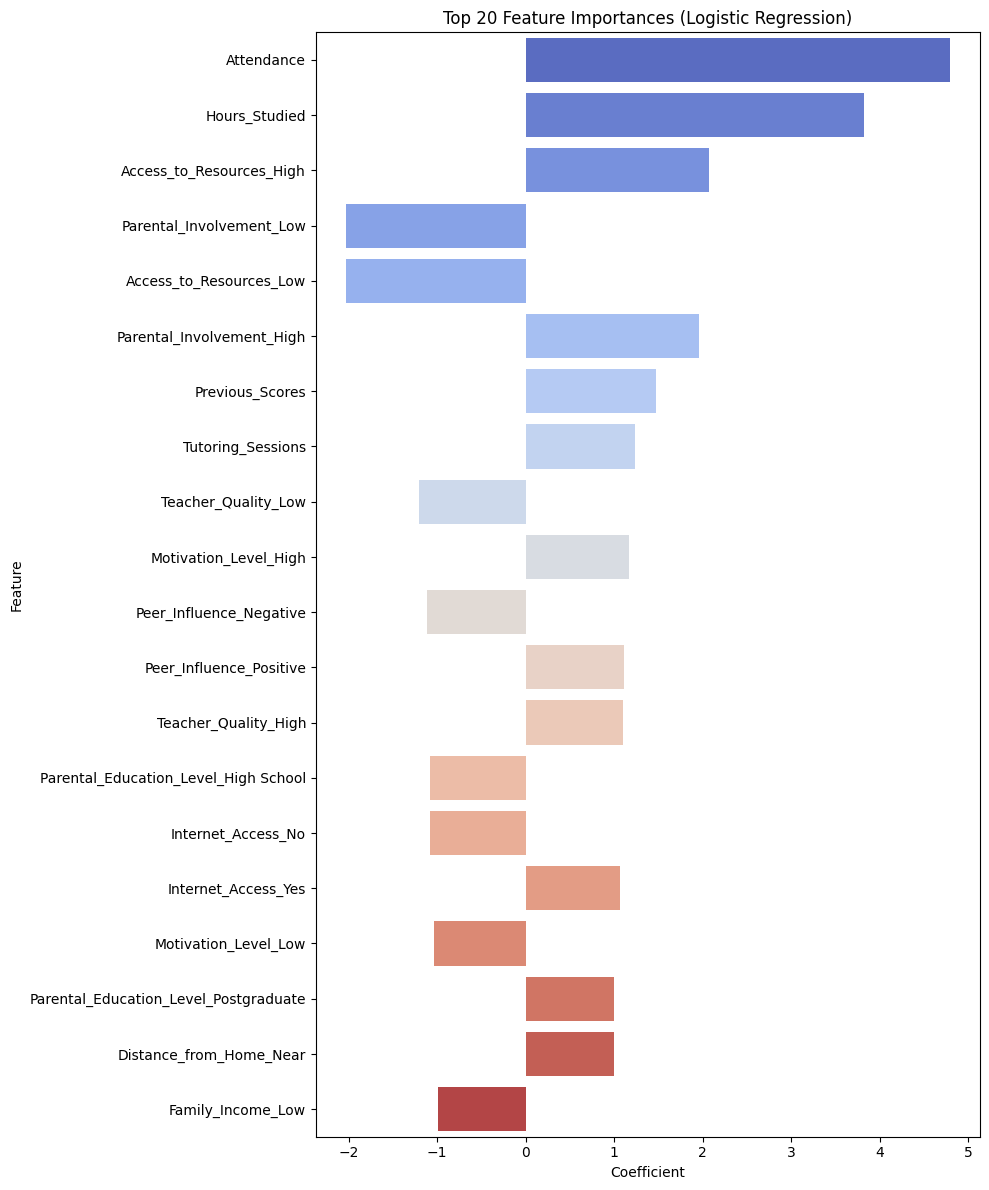

In [24]:
#------------- FEATURE IMPORTANCE ----------
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
importance["Abs_Coefficient"] = importance["Coefficient"].abs()
top_features = importance.sort_values("Abs_Coefficient", ascending=False).head(20)

plt.figure(figsize=(10,12))
sns.barplot(
    data=top_features, 
    x="Coefficient", 
    y="Feature", 
    palette="coolwarm"
)
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()

In [25]:
def predict_student(student_dict, threshold=0.5):
    new_df = pd.DataFrame([student_dict])
    # scale numeric
    new_df[numeric_cols] = scaler.transform(new_df[numeric_cols])
    # one-hot encode categorical
    encoded_new = encoder.transform(new_df[categorical_cols])
    encoded_new_df = pd.DataFrame(encoded_new, columns=encoder.get_feature_names_out(categorical_cols))
    encoded_new_df.index = new_df.index
    X_new = pd.concat([new_df[numeric_cols], encoded_new_df], axis=1)
    # predict
    prob = model.predict_proba(X_new)[:,1][0]
    pred = (prob >= threshold).astype(int)
    print(f"Predicted probability of Success: {prob:.2f}")
    print("Predicted class:", "Success" if pred==1 else "Fail")

In [26]:
new_student1 = {
    "Hours_Studied": 18,
    "Attendance": 65,
    "Parental_Involvement": "Low",
    "Access_to_Resources": "Medium",
    "Extracurricular_Activities": "No",
    "Sleep_Hours": 7,
    "Previous_Scores": 70,
    "Motivation_Level": "Medium",
    "Internet_Access": "Yes",
    "Tutoring_Sessions": 1,
    "Family_Income": "Medium",
    "Teacher_Quality": "High",
    "School_Type": "Public",
    "Peer_Influence": "Positive",
    "Physical_Activity": 3,
    "Learning_Disabilities": "No",
    "Parental_Education_Level": "College",
    "Distance_from_Home": "Near",
    "Gender": "Male"
}
predict_student(new_student1)

Predicted probability of Success: 0.00
Predicted class: Fail


In [27]:
# Example high-performing student
new_student2 = {
    "Hours_Studied": 30,
    "Attendance": 95,     
    "Parental_Involvement": "High",     
    "Access_to_Resources": "High",
    "Extracurricular_Activities": "Yes",
    "Sleep_Hours": 8,               
    "Previous_Scores": 90,       
    "Motivation_Level": "High",
    "Internet_Access": "Yes",
    "Tutoring_Sessions": 3,        
    "Family_Income": "High",
    "Teacher_Quality": "High",
    "School_Type": "Private",
    "Peer_Influence": "Positive",
    "Physical_Activity": 4,
    "Learning_Disabilities": "No",
    "Parental_Education_Level": "Postgraduate",
    "Distance_from_Home": "Near",
    "Gender": "Female"
}
predict_student(new_student2)

Predicted probability of Success: 1.00
Predicted class: Success
